# NBA Project

We have 1193 csv files including every single play of the 2017-2018 NBA season. The goal was to measure and predict how well would NBA teams perform in the other 120  games within that season.
Our conclusion: Luke Walton might have to go...

Load libraries

In [1]:
import os
import pandas as pd 
import numpy as np 
import re
np.warnings.filterwarnings('ignore')
from datetime import datetime

We found a way to loop through all of the files in the directory

In [51]:
Train_Files = []
for file in os.listdir("~/TRAIN/"):
    Train_Files.append(file)
    
#Train_Files
all_teams = []
for file_name in Train_Files:
    if file_name.endswith('.csv'):
        all_teams.append(file_name[24:27])
        all_teams.append(file_name[28:31])
all_teams = list(set(all_teams))
team_dict = {all_teams[team]: [] for team in range(len(all_teams))}
for team in team_dict:
    for file in Train_Files:
        if team in file:
            team_dict.get(team).append(file)
len(Train_Files)

1193

Now, we have the lineups separate for the home and away team, but we dont have an indicator in the dataset
for what is the home and away team. Therefore, we have to create separate datasets for 
home / away teams. 

In [3]:
Directory = "~/TRAIN/"

FinalData = None

for team in team_dict:
    
    # Create an Empty Data Frame so that we can merge # 

    TeamData = pd.DataFrame(columns = ['Lineup', 'ScoredConceded', 'points'])

    for file in team_dict.get(team):

        data = pd.read_csv(Directory + file)

        if ("@" + team) in file: 
            HomeAway = "Home"

            temp_data = data[['h1', 'h2', 'h3', 'h4', 'h5', 'team', 'points']]

            temp_data.columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'team', 'points']

            temp_data['ScoredConceded'] = np.where(temp_data['team'] == team, "Scored", "Conceded")    

            temp_data = temp_data.loc[temp_data['points'].notnull()]

            names = temp_data[['p1', 'p2', 'p3', 'p4', 'p5']].values.tolist()

            SortedLines = []

            for line in names: 

                SortedLines.append( sorted(line) )

            SortedLines = pd.DataFrame(SortedLines, columns = ['p1', 'p2', 'p3', 'p4', 'p5'])

            SortedLines['Lineup'] = SortedLines[['p1', 'p2', 'p3', 'p4', 'p5']].apply(lambda x: ', '.join(x), axis=1)
            

            SortedLines.reset_index(inplace = True)
            temp_data.reset_index(inplace = True)

            temp_data['Lineup'] = SortedLines['Lineup']

            temp_data = temp_data[['Lineup', 'ScoredConceded', 'points']]

            # Combine Data Files #

            TeamData = pd.concat([TeamData, temp_data])

        else:
            HomeAway = "Away"

            temp_data = data[['a1', 'a2', 'a3', 'a4', 'a5', 'team', 'points']]

            temp_data.columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'team', 'points']

            temp_data['ScoredConceded'] = np.where(temp_data['team'] == team, "Scored", "Conceded")    

            temp_data = temp_data.loc[temp_data['points'].notnull()]

            names = temp_data[['p1', 'p2', 'p3', 'p4', 'p5']].values.tolist()

            SortedLines = []

            for line in names: 

                SortedLines.append( sorted(line) )

            SortedLines = pd.DataFrame(SortedLines, columns = ['p1', 'p2', 'p3', 'p4', 'p5'])

            SortedLines['Lineup'] = SortedLines[['p1', 'p2', 'p3', 'p4', 'p5']].apply(lambda x: ', '.join(x), axis=1)
            

            SortedLines.reset_index(inplace = True)
            temp_data.reset_index(inplace = True)

            temp_data['Lineup'] = SortedLines['Lineup']

            temp_data = temp_data[['Lineup', 'ScoredConceded', 'points']]

            TeamData = pd.concat([TeamData, temp_data])
    # Collapse the data (pivot) using a pivot table to calculate the number of points scored / conceded #

    TeamData2 = pd.pivot_table(data = TeamData, index = ['Lineup','ScoredConceded'], values = 'points', aggfunc = [np.sum])

    TeamData2 = TeamData2.unstack().reset_index()

    # This command just resets the header, so that it is simpler to work with the column names#

    TeamData2.columns = TeamData2.columns.get_level_values(0)

    # This defines new column names #

    TeamData2.columns = ['Lineup', 'Conceded', 'Scored']

    # This calculates the +/-

    TeamData2['PlusMinus'] = TeamData2['Scored'] - TeamData2['Conceded']

    TeamData2['Team'] = team

    TeamData2.sort_values('PlusMinus', ascending = True)

    TeamData2.head()
    
    FinalData = pd.concat([FinalData, TeamData2])

FinalData.head()

,Lineup,Conceded,Scored,PlusMinus,Team
0,"Austin Rivers, Avery Bradley, Danilo Gallinari...",0.0,2.0,2.0,LAC
1,"Austin Rivers, Avery Bradley, Danilo Gallinari...",111.0,124.0,13.0,LAC
2,"Austin Rivers, Avery Bradley, Danilo Gallinari...",33.0,25.0,-8.0,LAC
3,"Austin Rivers, Avery Bradley, Danilo Gallinari...",NaN,0.0,NaN,LAC
4,"Austin Rivers, Avery Bradley, DeAndre Jordan, ...",12.0,18.0,6.0,LAC


Quick check for the dimension of the dataframe

In [4]:
FinalData.shape

(13540, 5)

We looked at the datafile intensively to find out: Does it make sense to fill the null fields in Scored and Conceded with 0s.
We made sure that the null fields didn't correspond with a change in game points to make sure that when we fill 0s, the result of our calculation wouldn't be affected.

In [5]:
FinalData['Scored']=FinalData['Scored'].fillna(0)
FinalData['Conceded']=FinalData['Conceded'].fillna(0)
FinalData['PlusMinus'] = FinalData['Scored']-FinalData['Conceded']

Again, a quick look at the dataframe to make sure everything looks good.
We also constantly use .describe() to make sure our parameters aren't ridiculous.

In [6]:
FinalData.head()

,Lineup,Conceded,Scored,PlusMinus,Team
0,"Austin Rivers, Avery Bradley, Danilo Gallinari...",0.0,2.0,2.0,LAC
1,"Austin Rivers, Avery Bradley, Danilo Gallinari...",111.0,124.0,13.0,LAC
2,"Austin Rivers, Avery Bradley, Danilo Gallinari...",33.0,25.0,-8.0,LAC
3,"Austin Rivers, Avery Bradley, Danilo Gallinari...",0.0,0.0,0.0,LAC
4,"Austin Rivers, Avery Bradley, DeAndre Jordan, ...",12.0,18.0,6.0,LAC


Here we made sure that our Lineup column isn't duplicated after our groupby function above.

In [47]:
FinalData['Lineup'].duplicated().sum()

0

In [8]:
#train_dataframe[['p1','p2','p3','p4','p5']] = train_dataframe['Lineup'].str.split(', ',expand=True)

# Get Length

After getting the plus/minus for each lineup in our ~ 1193 games. We wanted to know how many seconds did these line up play during the course of these games. We wanted to break down to the plus/minus per second level and then build our predictions from there.

In [9]:
from datetime import datetime
Directory = "~/TRAIN/"

FinalData2 = None

for team in team_dict:
    
    # Create an Empty Data Frame so that we can merge # 

    TeamData = pd.DataFrame(columns = ['Lineup', 'ScoredConceded', 'points','play_length'])

    for file in team_dict.get(team):

        data = pd.read_csv(Directory + file)

        if ("@" + team) in file: 
            HomeAway = "Home"

            temp_data = data[['h1', 'h2', 'h3', 'h4', 'h5', 'team', 'points','play_length']]

            temp_data.columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'team', 'points','play_length']

            temp_data['ScoredConceded'] = np.where(temp_data['team'] == team, "Scored", "Conceded")    

            temp_data = temp_data.loc[temp_data['play_length'].notnull()]

            names = temp_data[['p1', 'p2', 'p3', 'p4', 'p5']].values.tolist()

            SortedLines = []

            for line in names: 

                SortedLines.append( sorted(line) )

            SortedLines = pd.DataFrame(SortedLines, columns = ['p1', 'p2', 'p3', 'p4', 'p5'])

            SortedLines['Lineup'] = SortedLines[['p1', 'p2', 'p3', 'p4', 'p5']].apply(lambda x: ', '.join(x), axis=1)
            ## NEW COMMAND ### -- DIFFERENT FROM EARLIER FILE ##

            SortedLines.reset_index(inplace = True)
            temp_data.reset_index(inplace = True)

            temp_data['Lineup'] = SortedLines['Lineup']

            temp_data = temp_data[['Lineup', 'ScoredConceded', 'points','play_length']]
            

            # Combine Data Files #

            TeamData = pd.concat([TeamData, temp_data])


        else:
            HomeAway = "Away"

            temp_data = data[['a1', 'a2', 'a3', 'a4', 'a5', 'team', 'points','play_length']]

            temp_data.columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'team', 'points','play_length']

            temp_data['ScoredConceded'] = np.where(temp_data['team'] == team, "Scored", "Conceded")    

            temp_data = temp_data.loc[temp_data['play_length'].notnull()]

            names = temp_data[['p1', 'p2', 'p3', 'p4', 'p5']].values.tolist()

            SortedLines = []

            for line in names: 

                SortedLines.append( sorted(line) )

            SortedLines = pd.DataFrame(SortedLines, columns = ['p1', 'p2', 'p3', 'p4', 'p5'])

            SortedLines['Lineup'] = SortedLines[['p1', 'p2', 'p3', 'p4', 'p5']].apply(lambda x: ', '.join(x), axis=1)
            ## NEW COMMAND ### -- DIFFERENT FROM EARLIER FILE ##

            SortedLines.reset_index(inplace = True)
            temp_data.reset_index(inplace = True)

            temp_data['Lineup'] = SortedLines['Lineup']

            temp_data = temp_data[['Lineup', 'ScoredConceded', 'points','play_length']]
            
            
            TeamData = pd.concat([TeamData, temp_data])
            
    
    FinalData2 = pd.concat([FinalData2, TeamData])

FinalData2.head()

,Lineup,ScoredConceded,points,play_length
0,"Blake Griffin, Danilo Gallinari, DeAndre Jorda...",Conceded,NaN,0:00:00
1,"Blake Griffin, Danilo Gallinari, DeAndre Jorda...",Scored,NaN,0:00:00
2,"Blake Griffin, Danilo Gallinari, DeAndre Jorda...",Scored,0.0,0:00:20
3,"Blake Griffin, Danilo Gallinari, DeAndre Jorda...",Conceded,NaN,0:00:03
4,"Blake Griffin, Danilo Gallinari, DeAndre Jorda...",Conceded,0.0,0:00:19


Again, checking the dimension of the dataframe

In [10]:
FinalData2.shape

(1091150, 4)

Here we want to drop the points column to make sure when we merge the dataframes together, we won't get duplicated column for points.

In [11]:
dfdata2 = FinalData2.drop(columns=['points'])

We check for weird play_length/time values in the dataset. Apparently, some of the time was recorded weirdly to reflect clock resets. We went into the data to make sure that this was a valid assumption before proceeding with cleaning the '-' sign. There wasn't many of these but it affected the datetime conversion.

In [12]:
dafuq= dfdata2.loc[dfdata2.play_length.str.contains('-')]
dafuq['play_length'].unique()

array(['00:-12:00', '00:-5:00', '00:-11:34', '00:-11:13', '00:-11:14'],
      dtype=object)

In [13]:
dfdata2.loc[dfdata2.play_length.str.contains('-'), 'play_length'] = '00:00:00'
dfdata2['play_length']=dfdata2['play_length'].apply(lambda x: datetime.strptime(x, '%X'))
dfdata2['play_length']=dfdata2['play_length'].dt.second

In [15]:
dfdata2.head()

,Lineup,ScoredConceded,play_length
0,"Blake Griffin, Danilo Gallinari, DeAndre Jorda...",Conceded,0
1,"Blake Griffin, Danilo Gallinari, DeAndre Jorda...",Scored,0
2,"Blake Griffin, Danilo Gallinari, DeAndre Jorda...",Scored,20
3,"Blake Griffin, Danilo Gallinari, DeAndre Jorda...",Conceded,3
4,"Blake Griffin, Danilo Gallinari, DeAndre Jorda...",Conceded,19


Grouping the lineups by their total play_length

In [16]:
df2= dfdata2.groupby(by='Lineup').agg({'play_length':sum})

# putting the dataframes together together

We wanted to merge the play_length with the lineups using the lineup dataframe was the dataframe to join to.

In [17]:
df = pd.merge(FinalData, df2, on = ['Lineup'], how = 'left')

Check for null values and how the data look

In [18]:
df.isnull().sum()

Lineup         0
Conceded       0
Scored         0
PlusMinus      0
Team           0
play_length    0
dtype: int64

In [19]:
df.tail()

,Lineup,Conceded,Scored,PlusMinus,Team,play_length
13535,"Khem Birch, Mario Hezonja, Nikola Vucevic, She...",3.0,5.0,2.0,ORL,139
13536,"Khem Birch, Mario Hezonja, Rashad Vaughn, Shel...",3.0,1.0,-2.0,ORL,46
13537,"Khem Birch, Mario Hezonja, Rodney Purvis, Shel...",5.0,8.0,3.0,ORL,142
13538,"Khem Birch, Marreese Speights, Rodney Purvis, ...",14.0,11.0,-3.0,ORL,201
13539,"Khem Birch, Nikola Vucevic, Rodney Purvis, She...",4.0,2.0,-2.0,ORL,58


In [20]:
df.Team.nunique()

30

A small amount of the lineups recorded 0 seconds in play. For our calculation, we change these values to 1 second for the calculation to go through (without giving infinite values). Our argument was: if a lineup scored or conceded some points (plus or minus or scored or conceded > 0) and play_length ==0, that doesn't make any sense. So we made them played at least 1 second.
Then we calculated the point(s) scored per second and conceded per second of each individual lineups.

In [21]:
df.loc[df.play_length ==0,'play_length'] = 1
df['Scored_per_sec'] = df['Scored'] / df['play_length']
df['Conceded_per_sec'] = df['Conceded'] / df['play_length']

In [22]:
df.describe()

,Conceded,Scored,PlusMinus,play_length,Scored_per_sec,Conceded_per_sec
count,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000,13540.000000
mean,18.725332,18.725332,0.000000,510.201256,0.040899,0.048857
std,61.448996,64.625782,8.233599,1713.521486,0.077514,0.113430
min,0.000000,0.000000,-88.000000,1.000000,0.000000,0.000000
25%,3.000000,2.000000,-3.000000,80.000000,0.023392,0.026667
50%,7.000000,6.000000,0.000000,181.500000,0.035105,0.037037
75%,16.000000,15.000000,2.000000,410.000000,0.045113,0.048387
max,2108.000000,2181.000000,230.000000,57209.000000,3.000000,3.000000


# Test

We imported the test set with the lineup playtime. using similar methods we did for the train set.

In [58]:
Test_Files = []

for file in os.listdir("~/TEST/"):
    Test_Files.append(file)

#TEST_Files
all_teams = []
for file_name in Test_Files:
    if file_name.endswith('.csv'):
        all_teams.append(file_name[24:27])
        all_teams.append(file_name[28:31])
all_teams = list(set(all_teams))
team_dict = {all_teams[team]: [] for team in range(len(all_teams))}
for team in team_dict:
    for file in Test_Files:
        if team in file:
            team_dict.get(team).append(file)

len(Test_Files)

119

In [90]:

from datetime import datetime
Directory = "~/TEST/"

FinalDatatest = None

for team in team_dict:
    
    # Create an Empty Data Frame so that we can merge # 

    TeamData = pd.DataFrame(columns = ['Lineup', 'play_length','game_id'])

    for file in team_dict.get(team):

        data = pd.read_csv(Directory + file)

        if ("@" + team) in file: 
            HomeAway = "Home"

            temp_data = data[['h1', 'h2', 'h3', 'h4', 'h5','play_length','game_id']]

            temp_data.columns = ['p1', 'p2', 'p3', 'p4', 'p5','play_length','game_id']

            #temp_data['ScoredConceded'] = np.where(temp_data['team'] == team, "Scored", "Conceded")    

            temp_data = temp_data.loc[temp_data['play_length'].notnull()]

            names = temp_data[['p1', 'p2', 'p3', 'p4', 'p5']].values.tolist()

            SortedLines = []

            for line in names: 

                SortedLines.append( sorted(line) )

            SortedLines = pd.DataFrame(SortedLines, columns = ['p1', 'p2', 'p3', 'p4', 'p5'])

            SortedLines['Lineup'] = SortedLines[['p1', 'p2', 'p3', 'p4', 'p5']].apply(lambda x: ', '.join(x), axis=1)
            

            SortedLines.reset_index(inplace = True)
            temp_data.reset_index(inplace = True) 

            temp_data['Lineup'] = SortedLines['Lineup']

            temp_data = temp_data[['Lineup', 'play_length','game_id']]
            

            # Combine Data Files #

            TeamData = pd.concat([TeamData, temp_data])


        else:
            HomeAway = "Away"

            temp_data = data[['a1', 'a2', 'a3', 'a4', 'a5', 'play_length','game_id']]

            temp_data.columns = ['p1', 'p2', 'p3', 'p4', 'p5', 'play_length','game_id']

            #temp_data['ScoredConceded'] = np.where(temp_data['team'] == team, "Scored", "Conceded")    

            temp_data = temp_data.loc[temp_data['play_length'].notnull()]

            names = temp_data[['p1', 'p2', 'p3', 'p4', 'p5']].values.tolist()

            SortedLines = []

            for line in names: 

                SortedLines.append( sorted(line) )

            SortedLines = pd.DataFrame(SortedLines, columns = ['p1', 'p2', 'p3', 'p4', 'p5'])

            SortedLines['Lineup'] = SortedLines[['p1', 'p2', 'p3', 'p4', 'p5']].apply(lambda x: ', '.join(x), axis=1)
            

            SortedLines.reset_index(inplace = True)
            temp_data.reset_index(inplace = True)

            temp_data['Lineup'] = SortedLines['Lineup']

            temp_data = temp_data[['Lineup','play_length','game_id']]
            
            
            TeamData = pd.concat([TeamData, temp_data])
            
    TeamData['Team'] = team        
    
    FinalDatatest = pd.concat([FinalDatatest, TeamData])

FinalDatatest.head()

,Lineup,play_length,game_id,Team
0,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",00:00:00,"=""0021700245""",LAC
1,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",00:00:00,"=""0021700245""",LAC
2,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",00:00:22,"=""0021700245""",LAC
3,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",00:00:22,"=""0021700245""",LAC
4,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",00:00:14,"=""0021700245""",LAC


In [99]:
FinalDatatest['game_id'].nunique()

119

In [92]:
FinalDatatest.head()

,Lineup,play_length,game_id,Team
0,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",00:00:00,"=""0021700245""",LAC
1,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",00:00:00,"=""0021700245""",LAC
2,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",00:00:22,"=""0021700245""",LAC
3,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",00:00:22,"=""0021700245""",LAC
4,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",00:00:14,"=""0021700245""",LAC


In [93]:
FinalDatatest.loc[FinalDatatest['play_length'].str.contains('-'), 'play_length'] = '00:00:00'
FinalDatatest['play_length']=FinalDatatest['play_length'].apply(lambda x: datetime.strptime(x, '%X'))
FinalDatatest['play_length']=FinalDatatest['play_length'].dt.second

In [95]:
FinalDatatest.shape

(110194, 4)

In [75]:
# FinalDatatest['game_id'] = FinalDatatest['game_id'].str.replace('"','')
# FinalDatatest['game_id'] = FinalDatatest['game_id'].str.replace('=','')

In [96]:
FinalDatatest.describe()

,play_length
count,110194.000000
mean,6.252972
std,6.960576
min,0.000000
25%,0.000000
50%,3.000000
75%,11.000000
max,35.000000


drop from train set to avoid duplicates

In [98]:
dftrain = df.drop(columns=['play_length','Conceded','Scored','Team','PlusMinus']) 

In [101]:
dftrain.describe()

,Scored_per_sec,Conceded_per_sec
count,13540.000000,13540.000000
mean,0.040899,0.048857
std,0.077514,0.113430
min,0.000000,0.000000
25%,0.023392,0.026667
50%,0.035105,0.037037
75%,0.045113,0.048387
max,3.000000,3.000000


In [102]:
dff_testmerged = pd.merge(FinalDatatest,dftrain, on = 'Lineup', how = 'left')

Making sure we didn't lose any of our 119 games

In [107]:
dff_testmerged['game_id'].nunique()

119

In [104]:
dff_testmerged.head()

,Lineup,play_length,game_id,Team,Scored_per_sec,Conceded_per_sec
0,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",0,"=""0021700245""",LAC,0.039929,0.040989
1,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",0,"=""0021700245""",LAC,0.039929,0.040989
2,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",22,"=""0021700245""",LAC,0.039929,0.040989
3,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",22,"=""0021700245""",LAC,0.039929,0.040989
4,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",14,"=""0021700245""",LAC,0.039929,0.040989


Simple calculation of scored and conceded points.

In [106]:
dff_testmerged['score_calculated'] = dff_testmerged['play_length']*dff_testmerged['Scored_per_sec']
dff_testmerged['conceded_calculated'] = dff_testmerged['play_length']*dff_testmerged['Conceded_per_sec']

In [108]:
dff_testmerged.describe()

,play_length,Scored_per_sec,Conceded_per_sec,score_calculated,conceded_calculated
count,110194.000000,109555.000000,109555.000000,109555.000000,109555.000000
mean,6.252972,0.037253,0.037841,0.231577,0.232213
std,6.960576,0.017633,0.030690,0.272174,0.273775
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.032927,0.032520,0.000000,0.000000
50%,3.000000,0.037211,0.036301,0.118638,0.120337
75%,11.000000,0.040537,0.040729,0.401003,0.398090
max,35.000000,1.000000,2.000000,3.040000,3.000000


In [115]:
insight1 = dff_testmerged.groupby(by=['game_id','Team']).agg({'score_calculated':sum,'conceded_calculated':sum})

In [116]:
insight1= insight1.reset_index()
insight1['game_id'].nunique()

119

In [117]:
insight1.head()

,game_id,Team,score_calculated,conceded_calculated
0,21700095,HOU,113.053018,105.644645
1,21700095,PHI,106.294480,106.244342
2,21700152,CHA,111.637534,116.602312
3,21700152,NYK,107.833701,94.465786
4,21700164,LAL,102.211105,99.833124


# Train for individual player

In [132]:
df.head()

,Lineup,Conceded,Scored,PlusMinus,Team,play_length,Scored_per_sec,Conceded_per_sec,p1,p2,p3,p4,p5,scoredpersec_perplayer,concededpersec_perplayer,PlusMinuspersec,PlusMinuspersec_perplayer
0,"Austin Rivers, Avery Bradley, Danilo Gallinari...",0.0,2.0,2.0,LAC,67,0.029851,0.000000,Austin Rivers,Avery Bradley,Danilo Gallinari,DeAndre Jordan,Lou Williams,0.005970,0.000000,0.029851,0.005970
1,"Austin Rivers, Avery Bradley, Danilo Gallinari...",111.0,124.0,13.0,LAC,3704,0.033477,0.029968,Austin Rivers,Avery Bradley,Danilo Gallinari,DeAndre Jordan,Tobias Harris,0.006695,0.005994,0.003510,0.000702
2,"Austin Rivers, Avery Bradley, Danilo Gallinari...",33.0,25.0,-8.0,LAC,760,0.032895,0.043421,Austin Rivers,Avery Bradley,Danilo Gallinari,Lou Williams,Montrezl Harrell,0.006579,0.008684,-0.010526,-0.002105
3,"Austin Rivers, Avery Bradley, Danilo Gallinari...",0.0,0.0,0.0,LAC,14,0.000000,0.000000,Austin Rivers,Avery Bradley,Danilo Gallinari,Montrezl Harrell,Tobias Harris,0.000000,0.000000,0.000000,0.000000
4,"Austin Rivers, Avery Bradley, DeAndre Jordan, ...",12.0,18.0,6.0,LAC,396,0.045455,0.030303,Austin Rivers,Avery Bradley,DeAndre Jordan,Lou Williams,Tobias Harris,0.009091,0.006061,0.015152,0.003030


Split and calculate per play on avg contribution in each lineup

In [131]:
df[['p1','p2','p3','p4','p5']] = df['Lineup'].str.split(', ',expand=True)
df['PlusMinuspersec']  = df['PlusMinus'] / df['play_length']
df['PlusMinuspersec_perplayer']= df['PlusMinuspersec'] /5.0

In [134]:
p1 = df.groupby('p1').agg({'PlusMinuspersec_perplayer':'mean'})
p2 = df.groupby('p2').agg({'PlusMinuspersec_perplayer':'mean'})
p3 = df.groupby('p3').agg({'PlusMinuspersec_perplayer':'mean'})
p4 = df.groupby('p4').agg({'PlusMinuspersec_perplayer':'mean'})
p5 = df.groupby('p5').agg({'PlusMinuspersec_perplayer':'mean'})
playa_df= pd.concat([p1, p2, p3, p4, p5], ignore_index=False)
playa_df=playa_df.reset_index()
playa_df.columns=['Playa','PlusMinuspersec_perplayer']
playa = playa_df.groupby('Playa').agg({'PlusMinuspersec_perplayer':'mean'}).sort_values(by='PlusMinuspersec_perplayer', ascending = False)

# train for individual playa

In [166]:
playa.tail(25)

,PlusMinuspersec_perplayer
Playa,
Isaiah Whitehead,-0.008675
Bam Adebayo,-0.009115
Tyler Lydon,-0.009231
Edmond Sumner,-0.009231
Damyean Dotson,-0.009325
D.J. Wilson,-0.009436
Larry Nance Jr.,-0.009611
Alex Poythress,-0.009975
Kristaps Porzingis,-0.010170


# TEST for individual player

In [140]:
FinalDatatest.head()

,Lineup,play_length,game_id,Team,p1,p2,p3,p4,p5
0,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",0,"=""0021700245""",LAC,Austin Rivers,Blake Griffin,DeAndre Jordan,Patrick Beverley,Wesley Johnson
1,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",0,"=""0021700245""",LAC,Austin Rivers,Blake Griffin,DeAndre Jordan,Patrick Beverley,Wesley Johnson
2,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",22,"=""0021700245""",LAC,Austin Rivers,Blake Griffin,DeAndre Jordan,Patrick Beverley,Wesley Johnson
3,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",22,"=""0021700245""",LAC,Austin Rivers,Blake Griffin,DeAndre Jordan,Patrick Beverley,Wesley Johnson
4,"Austin Rivers, Blake Griffin, DeAndre Jordan, ...",14,"=""0021700245""",LAC,Austin Rivers,Blake Griffin,DeAndre Jordan,Patrick Beverley,Wesley Johnson


In [139]:
FinalDatatest[['p1','p2','p3','p4','p5']] = FinalDatatest['Lineup'].str.split(', ',expand=True)

# for the 119 games in test

In [158]:
insight1.head()

,game_id,Team,score_calculated,conceded_calculated
0,21700095,HOU,113.053018,105.644645
1,21700095,PHI,106.294480,106.244342
2,21700152,CHA,111.637534,116.602312
3,21700152,NYK,107.833701,94.465786
4,21700164,LAL,102.211105,99.833124


Assuming gameID progress chronologically, the graph below shows the scores calculated and conceded over gameID.

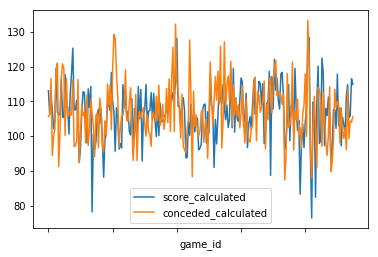

In [163]:
insight1.plot(x="game_id", y=["score_calculated", "conceded_calculated"])

In [142]:
#max scored game each team
insight1.loc[insight1.score_calculated == max(insight1.score_calculated)]

,game_id,Team,score_calculated,conceded_calculated
203,"=""0021701152""",MIL,128.356053,121.958616


In [143]:
#min scored game each team
insight1.loc[insight1.score_calculated == min(insight1.score_calculated)]

,game_id,Team,score_calculated,conceded_calculated
205,"=""0021701155""",SAC,76.50663,88.082948


In [145]:
#max conceded 
insight1.loc[insight1.conceded_calculated == max(insight1.conceded_calculated)]

,game_id,Team,score_calculated,conceded_calculated
202,"=""0021701152""",DEN,127.57837,133.289801


In [146]:
#min conceded
insight1.loc[insight1.conceded_calculated == min(insight1.conceded_calculated)]

,game_id,Team,score_calculated,conceded_calculated
184,"=""0021701056""",GSW,96.362009,87.388087


In [164]:
#highest avg team score: 
insight1.groupby('Team').agg({'score_calculated':'mean'}).sort_values('score_calculated', ascending = False).head(1)

,score_calculated
Team,
HOU,115.325283


In [165]:
#lowest avg team score:
insight1.groupby('Team').agg({'score_calculated':'mean'}).sort_values('score_calculated', ascending = False).tail(1)

,score_calculated
Team,
SAC,98.437139


In [154]:
#team with most games
insight1.groupby('Team').agg({'Team':'count'}).sort_values('Team', ascending = False).head(1)

,Team
Team,
PHI,14


In [155]:
#team with least games in train
insight1.groupby('Team').agg({'Team':'count'}).sort_values('Team', ascending = False).tail(1)

,Team
Team,
MEM,4
